In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 

In [4]:
#directories that would be using 
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/'
WLFF = '/Users/Ismael/code/lensing/WLFF/'
aegis = '/Users/Ismael/aegis/data/'
SEx = '/Users/Ismael/aegis/data/sextractor_runs/'
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data'
temp_data = '/Users/Ismael/temp_data'
os.chdir(WLD)
import descwl

In [19]:
#inputs, put all input files in a dict, 
inputs = dict(
input_name = '/Users/Ismael/aegis/data/intermediate_fits/section001.fits',
input_source_fits = '/Users/Ismael/aegis/data/sextractor_runs/test1/image.fits',
output_name = '/Users/Ismael/aegis/data/sextractor_runs/test1/out.cat',
output_name_dawson = '/Users/Ismael/aegis/data/sextractor_runs/test1/out_dawson.cat',
config_file = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data/sextractor_runs/default.sex',
config_file_dawson = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data/sextractor_runs/default_dawson.sex',
final_fits = '/Users/Ismael/aegis/data/sextractor_runs/test1/final_fits.fits',
final_fits_dawson = '/Users/Ismael/aegis/data/sextractor_runs/test1/final_fits_dawson.fits',
output_name_slac='/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data/sextractor_runs/test1/out.cat',     
output_name_slac_dawson='/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data/sextractor_runs/test1/out_dawson.cat',     
input_source_fits_slac='/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data/sextractor_runs/test1/image.fits'  
)

In [20]:
#convert inputs to location in temp
temps = dict()
for f in inputs: 
    l = inputs[f].split("/")
    temp_file = '{0}{1}'.format('/Users/Ismael/temp_data/',l[-1])
    temps[f] = temp_file

In [7]:
#others/outputs
matched_image = '/Users/Ismael/temp_data/matched_check4.png'
final_fits = '/Users/Ismael/temp_data/final_fits.fits'

### copy to local 

In [52]:
#rm whatever is in the temp_data folder. 
subprocess.call('rm temp_data/*', shell=True)

1

In [57]:
for f in inputs: 
    subprocess.call('cp {0} {1}'.format(inputs[f],temp_data),shell=True)

### write image from catalog into the correct format for it to be sextracted. 

In [ ]:
import descwl
reader = descwl.output.Reader(input_name)
results = reader.results
results.add_noise(noise_seed=0) #same noise_seed for all? 
f = fits.PrimaryHDU(results.survey.image.array)
f.writeto(inputs['input_source_fits'])

In [8]:
#run SExtractor: not sure how to do this using slac shell... 
cmd = 'sex {0} -c {1} -CATALOG_NAME {2}'.format(inputs['input_source_fits_slac'],inputs['config_file_dawson'],inputs['output_name_slac_dawson'])
print cmd 

sex /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data/sextractor_runs/test1/image.fits -c /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data/sextractor_runs/default_dawson.sex -CATALOG_NAME /nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data/sextractor_runs/test1/out_dawson.cat


### Read data 

In [24]:
#read corresponding catalog 
cat = descwl.output.Reader(temps['input_name']).results
table = cat.table
detected,matched,indices,distance = cat.match_sextractor(temps['output_name_dawson'])

### Check consistency of SExtracted objects 

In [ ]:
#image showing matched objects in the image. 
cmd = './display.py -o {0} --input-name {1} --crop --group 402700155390 --match-catalog {2} --magnification 4 --no-show'.format(matched_image,input_name,output_name)
out = subprocess.check_output(cmd,shell=True)
print out 

In [ ]:
#distance of matched and simulated object distance. 
plt.hist(distance,bins=100,range=(0,1))

"""It is a little strange, let's check the matched image"""
"""The distances are a lot better! now after correcting the png thing. """

### how are indices ordered? 

In [ ]:
print detected[0]['X_IMAGE']
print table[indices[0]]['dx'] 
#notice they are almost the same and this is the corresponding element

### Analysis of results, 

In [25]:
width, height = 4500,4500
pixel_scale = .2 

In [26]:
#convert to arcsecs and relative to image_center 
detected['X_IMAGE'] = (detected['X_IMAGE'] - 0.5*width - 0.5)*pixel_scale
detected['Y_IMAGE'] = (detected['Y_IMAGE'] - 0.5*height - 0.5)*pixel_scale

#convert second moments arcsecs 
detected['X2_IMAGE']*=pixel_scale**2 
detected['Y2_IMAGE']*=pixel_scale**2 
detected['XY_IMAGE']*=pixel_scale**2 

In [27]:
# calculate size from moments X2_IMAGE,Y2_IMAGE,XY_IMAGE -> remember in pixel**2 so have to convert to arcsecs. 
sigmas = []
for x2,y2,xy in zip(detected['X2_IMAGE'],detected['Y2_IMAGE'],detected['XY_IMAGE']):
    second_moments = np.array([[x2,xy],[xy,y2]])
    sigma = np.linalg.det(second_moments)**(+1./4) #should be a plus 
    sigmas.append(sigma)
SIGMA = Table.Column(name='SIGMA',data=sigmas)
detected.add_column(SIGMA)

# #add sizes of the corresponding entries from lsst to the detected table. 
# SIGMA_M = Table.Column(name='SIGMA_M', data=table[indices]['sigma_m'])
# detected.add_column(SIGMA_M) 

(array([  1.18330000e+04,   3.13600000e+03,   3.68000000e+02,
          7.50000000e+01,   2.40000000e+01,   1.20000000e+01,
          2.00000000e+00,   4.00000000e+00,   3.00000000e+00,
          2.00000000e+00]),
 array([ 0.11528787,  0.44318394,  0.77108001,  1.09897608,  1.42687215,
         1.75476822,  2.08266429,  2.41056036,  2.73845643,  3.06635249,
         3.39424856]),
 <a list of 10 Patch objects>)

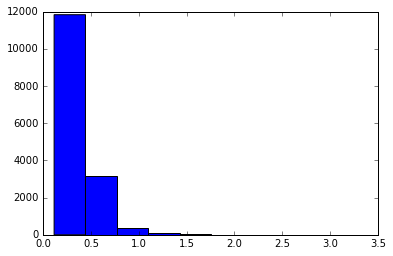

In [28]:
plt.hist(detected['SIGMA'])

In [169]:
#algorithm for ambiguous blends - returns rows of ambiguously blended objects in cat. 
def detected_ambiguous_blends1(table,matched_indices,detected):
    ambiguous_blends_indices = set([])
    for index,gal_row in enumerate(table):
        if gal_row['match'] == -1: 
            
            #search for least effective separation SExtracted object.
            effective_distances = list(np.sqrt((detected['X_IMAGE']-gal_row['dx'])**2 + (detected['Y_IMAGE']-gal_row['dy'])**2)/(detected['SIGMA'] + gal_row['psf_sigm']))
            
            #find minimum distance index 
            minimum_index = effective_distances.index(min(effective_distances))
#             if effective_distances[minimum_index]<1.:
#                 print matched_indices[minimum_index]
            #check criterion and of corresponding indices of table 
            if effective_distances[minimum_index] < 1.: 
                ambiguous_blends_indices.add(index)
                ambiguous_blends_indices.add(matched_indices[minimum_index])
    return ambiguous_blends_indices

In [31]:
#algorithm for ambiguous blends - returns rows of ambiguously blended objects in cat. 
#the difference is that it tags all objects <1. effective distance as blended. 
def detected_ambiguous_blends2(table,matched_indices,detected):
    ambiguous_blends_indices = []
    for index,gal_row in enumerate(table):
        if gal_row['match'] == -1: 
            
            #search for least effective separation SExtracted object.
            effective_distances = list(np.sqrt((detected['X_IMAGE']-gal_row['dx'])**2 + (detected['Y_IMAGE']-gal_row['dy'])**2)/(detected['SIGMA'] + gal_row['psf_sigm']))
            
#             #we can see distribution
#             for distance in effective_distances:
#                 if distance<3.:
#                     plot_distances.append(distance)
                    
            #mark all objects with effective distance <1. as ambiguosly blended. 
            marked_indices = [matched_indices[i] for i,distance in enumerate(effective_distances) if distance < 1.]
            #check criterion and of corresponding indices of table 
            if len(marked_indices) > 0:
                ambiguous_blends_indices.append(index)
                ambiguous_blends_indices.extend(marked_indices)
    return set(ambiguous_blends_indices)

In [120]:
ambg_blends1 = detected_ambiguous_blends1(table, indices, detected) #just to check dawson. 

In [32]:
ambg_blends2 = detected_ambiguous_blends2(table, indices, detected)

In [33]:
len(ambg_blends2)

8446

In [34]:
ambg_blends_indices = list(ambg_blends2)
ambg_blends_ids = list(table[ambg_blends_indices]['db_id'])

In [35]:
#add columns to table of undetected and ambiguosly blended 
ambigous_blend_column = []
for i,gal_row in enumerate(table):
    if i in ambg_blends_indices:
        ambigous_blend_column.append(True)
    else: 
        ambigous_blend_column.append(False)
column = Table.Column(name='ambig_blend',data=ambigous_blend_column)
table.add_column(column)

In [36]:
#create new copy of fits_file with this new table. 
subprocess.call('cp {0} {1}'.format(temps['input_name'],temps['final_fits_dawson']),shell=True)
f = fits.open(temps['final_fits_dawson'])  
#replace table and write file
f[1]= astropy.io.fits.table_to_hdu(table)
subprocess.call('rm {0}'.format(temps['final_fits_dawson']),shell=True)
f.writeto(temps['final_fits_dawson']) #overwrites the existing one. 

### Make sure ambigous blends make sense

In [41]:
cmd = './display.py -o {0} --view-region [350,400,350,400] --select "ambig_blend==True" --input-name {1} --match-catalog {2} --magnification 4 --match-color CYAN --no-display'.format('/Users/Ismael/temp_data/matched_check25_dawson.png',temps['final_fits_dawson'],temps['output_name_dawson'])
out = subprocess.check_output(cmd,shell=True)
print out 

In [42]:
cmd = './display.py -o {0} --view-region [350,400,350,400] --select-region [150,200,150,200] --input-name {1} --match-catalog {2} --magnification 4 --match-color CYAN --no-display'.format('/Users/Ismael/temp_data/matched_check25x_dawson.png',temps['final_fits_dawson'],temps['output_name_dawson'])
out = subprocess.check_output(cmd,shell=True)
print out 

### analysis of final_fits 

In [39]:
t = Table.read(temps['final_fits_dawson'])

In [40]:
float(len(t[(t['match'] != -1) & (t['ambig_blend'] == True)]))/ len(t[t['match'] != -1]) #number to compare to Dawson which is about 15%-20%

0.248932591538362